# Root inference with a neural network model

__Obejctive:__ experiment with generating data and fitting a NN model to predict the root.

In [95]:
import os
import sys
from tqdm import trange
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

sys.path.append('../modules/')

from logger import get_logger
from tree_generation import calcrho, generate_trees, compute_rho_entropy
from models import FFNN
from training import training_step, EarlyStopper
from model_evaluation import compute_accuracy, load_experiment_catalog, save_experiment_info
from plotting import plot_training_history

sys.path.append('../scripts/')

from RootInference_current import get_M, get_leaves

sns.set_theme()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Available device:', device)

logger = get_logger('nn_test')

%load_ext autoreload
%autoreload 2

Available device: cuda
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate dataset

In [13]:
DATA_DIR = '../data/'
EXPERIMENT_CATALOG_PATH = '../data/experiment_catalog.csv'

In [76]:
epsilons = np.logspace(-5,0,12)
epsilons = np.insert(epsilons,0,0)

sigmas = np.linspace(0,3,16)

np.random.seed(14)

n_samples = 8000
k = 5
q = 4
matrix_type = 'mixed_index_sets'
calcrho_kwargs = dict(
    q=q,
    sigma=sigmas[-1],
    epsilon=epsilons[0]
)

rho = calcrho(matrix_type, **calcrho_kwargs)
rho, trees, roots, leaves = generate_trees(rho, n_samples, k, q)

rho_entropy = compute_rho_entropy(rho, q)

roots, leaves, leaves.shape, rho_entropy, rho

/home/moscato/projects/tree-language/notebooks/../scripts/RootInference_current.py:14: RuntimeWarning: divide by zero encountered in log
  h = sigma*np.random.randn(q,q,q) + np.log(epsilon) # Actually parametrize with logits


(array([2, 3, 0, ..., 1, 3, 0]),
 array([[2, 1, 2, ..., 3, 1, 2],
        [1, 3, 2, ..., 3, 1, 2],
        [1, 3, 1, ..., 3, 1, 0],
        ...,
        [1, 3, 0, ..., 2, 1, 2],
        [2, 1, 0, ..., 3, 1, 2],
        [1, 3, 0, ..., 2, 1, 2]]),
 (8000, 32),
 0.12189233846004117,
 array([[[5.01800208e-05, 1.60301285e-03, 0.00000000e+00, 0.00000000e+00],
         [8.83768278e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 1.14578529e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
        [[0.00000000e+00, 0.00000000e+00, 3.66913256e-02, 0.00000000e+00],
         [0.00000000e+00, 3.47385663e-02, 0.00000000e+00, 7.44954958e-01],
         [0.00000000e+00, 1.83615150e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+

In [77]:
# # # Save generated data.
# dataset_name = 'exp_2'

# dataset_dir = os.path.join(DATA_DIR, dataset_name)

# if not os.path.exists(dataset_dir):
#     os.makedirs(dataset_dir)

#     logger.info(f'Created data directory: {dataset_dir}')

# with open(os.path.join(dataset_dir, 'rho.npy'), 'wb') as f:
#     np.save(f, rho)

# with open(os.path.join(dataset_dir, 'roots.npy'), 'wb') as f:
#     np.save(f, roots)

# with open(os.path.join(dataset_dir, 'trees.npy'), 'wb') as f:
#     np.save(f, trees)

# with open(os.path.join(dataset_dir, 'leaves.npy'), 'wb') as f:
#     np.save(f, leaves)

In [78]:
# # # To load a saved dataset.
# dataset_name = 'exp_1'

# dataset_dir = os.path.join(DATA_DIR, dataset_name)

# with open(os.path.join(dataset_dir, 'rho.npy'), 'rb') as f:
#     rho = np.load(f)

# with open(os.path.join(dataset_dir, 'roots.npy'), 'rb') as f:
#     roots = np.load(f)

# with open(os.path.join(dataset_dir, 'trees.npy'), 'rb') as f:
#     trees = np.load(f)

# with open(os.path.join(dataset_dir, 'leaves.npy'), 'rb') as f:
#     leaves = np.load(f)

# q = np.unique(roots).shape[0]

# print(f'N roots: {q} | N leaves: {leaves.shape[1]} | N samples: {leaves.shape[0]}')

## Model

In [79]:
# def mask_input(leaves, prob, masked_symbols_bound=1):
#     """
#     """
#     for i in range(leaves.shape[0]):
#         masked_symbols = 0
        
#         for j in range(leaves.shape[1]):
#             if np.random.uniform() < prob:
#                 leaves[i, j] 

In [80]:
# # Train-test split.
# test_frac = .2

# test_indices = np.random.choice(range(leaves.shape[0]), int(leaves.shape[0] * test_frac), replace=False)
# train_indices = np.array(list(set(range(leaves.shape[0])) - set(test_indices)))

# x_train = torch.nn.functional.one_hot(torch.from_numpy(leaves[train_indices, :]), num_classes=q).to(dtype=torch.float32).to(device=device)
# y_train = torch.nn.functional.one_hot(torch.from_numpy(roots[train_indices]), num_classes=q).to(dtype=torch.float32).to(device=device)
# x_test = torch.nn.functional.one_hot(torch.from_numpy(leaves[test_indices, :]), num_classes=q).to(dtype=torch.float32).to(device=device)
# y_test = torch.nn.functional.one_hot(torch.from_numpy(roots[test_indices]), num_classes=q).to(dtype=torch.float32).to(device=device)

x_train = torch.nn.functional.one_hot(torch.from_numpy(leaves), num_classes=q).to(dtype=torch.float32).to(device=device)
y_train = torch.nn.functional.one_hot(torch.from_numpy(roots), num_classes=q).to(dtype=torch.float32).to(device=device)

n_test_samples = 2000

_, _, test_roots, test_leaves = generate_trees(rho, n_test_samples, k, q)

x_test = torch.nn.functional.one_hot(torch.from_numpy(test_leaves), num_classes=q).to(dtype=torch.float32).to(device=device)
y_test = torch.nn.functional.one_hot(torch.from_numpy(test_roots), num_classes=q).to(dtype=torch.float32).to(device=device)

x_train.shape, x_test.shape

(torch.Size([8000, 32, 4]), torch.Size([2000, 32, 4]))

In [89]:
dims = [leaves.shape[-1], 64, q]

model = FFNN(
    dims=dims,
    activation='relu',
    output_activation='softmax',
    batch_normalization=False,
    concatenate_last_dim=True
).to(device=device)

print(f'N params: {sum(p.numel() for p in model.parameters())}')

loss_fn = torch.nn.CrossEntropyLoss()

epoch_counter = 0

training_history = {
    'training_loss': [],
    'val_loss': [],
    'training_accuracy': [],
    'val_accuracy': []
}

# Test.
loss_fn(
    model(x_train),
    y_train
)

N params: 8516


tensor(1.3878, device='cuda:0', grad_fn=<DivBackward1>)

100%|█████████████████| 150/150 [00:46<00:00,  3.20it/s, training_accuracy=tensor(0.8765), training_loss=tensor(0.8660), val_accuracy=tensor(0.7200, device='cuda:0'), val_loss=tensor(1.0227, device='cuda:0')]
2024-03-29 11:43:11,514 - nn_test - INFO - Last epoch: 338
2024-03-29 11:43:11,615 - nn_test - INFO - Final test accuracy: 0.7200000286102295 (baseline: 0.25)


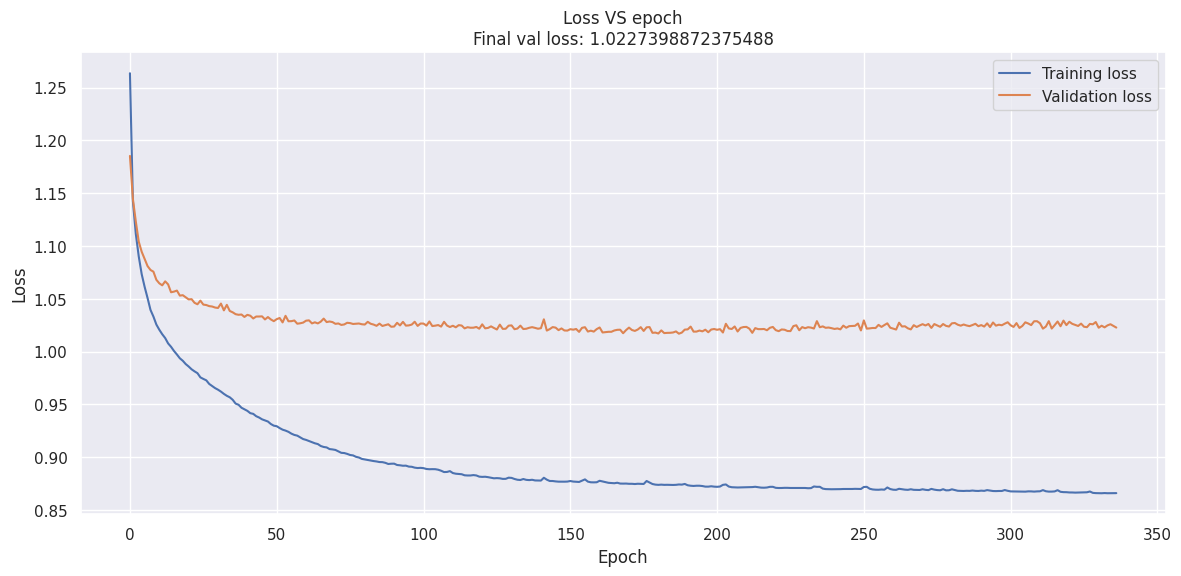

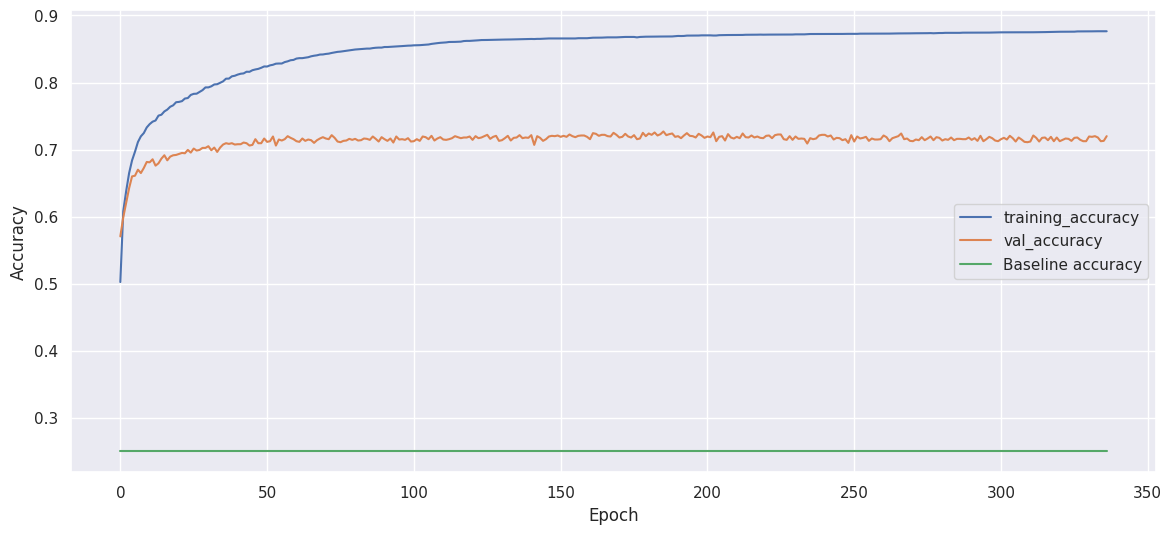

In [94]:
learning_rate = 1e-3
batch_size = 32

optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=learning_rate
)

# early_stopper = EarlyStopper(
#     patience=5,
#     min_delta=0.
# )
early_stopper = None

training_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train, y_train),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

n_epochs = 150

# Training loop.
with trange(n_epochs) as pbar:
    for i in pbar:
        epoch_counter += 1
    
        training_loss_batches = []
        training_accuracy_batches = []
    
        for batch in training_loader:
            training_batch, training_targets = batch
        
            training_loss_batch, _ = training_step(
                (training_batch, training_targets),
                model,
                loss_fn,
                optimizer,
            )
    
            training_loss_batches.append(training_loss_batch)
    
            # Compute the training accuracy over the batch and append it to
            # the corresponding list.
            training_accuracy_batch = compute_accuracy(model(training_batch), training_targets)
            training_accuracy_batches.append(training_accuracy_batch)
    
        # Training loss and accuracy for one epoch is computed as the average
        # training loss over the batches.
        training_loss = torch.tensor(training_loss_batches).mean()
        training_accuracy = torch.tensor(training_accuracy_batches).mean()
    
        training_history['training_loss'].append(training_loss)
        training_history['training_accuracy'].append(training_accuracy)
    
        if x_test is not None:
            with torch.no_grad():
                val_loss = loss_fn(model(x_test), y_test)
                val_accuracy = compute_accuracy(model(x_test), y_test)
        else:
            val_loss = None
            val_accuracy = None
    
        training_history['val_loss'].append(
            val_loss if val_loss is not None else None
        )
    
        training_history['val_accuracy'].append(
            val_accuracy if val_accuracy is not None else None
        )

        pbar.set_postfix(
            training_loss=training_history['training_loss'][-1],
            training_accuracy=training_history['training_accuracy'][-1],
            val_loss=training_history['val_loss'][-1],
            val_accuracy=training_history['val_accuracy'][-1]
        )
        # if (i < 50) or (i % 50 == 0):
        #     logger.debug(
        #         f'Epoch: {epoch_counter}'
        #         f' | Training loss: {training_history["training_loss"][-1]}'
        #         f' | Validation loss: {training_history["val_loss"][-1]}'
        #     )
    
        if (x_test is not None) and (early_stopper is not None):
            if early_stopper.early_stop(training_history['val_loss'][-1]):
                logger.debug(
                    f'Early stopping epoch: {epoch_counter}'
                    f' | Training loss: {training_history["training_loss"][-1]}'
                    f' | Validation loss: {training_history["val_loss"][-1]}'
                )
                
                break
        elif (early_stopper is not None):
            if early_stopper.early_stop(training_history['training_loss'][-1]):
                logger.debug(
                    f'Early stopping epoch: {epoch_counter}'
                    f' | Training loss: {training_history["training_loss"][-1]}'
                )
                
                break


training_history['training_loss'] = torch.tensor(training_history['training_loss']).tolist()
training_history['training_accuracy'] = torch.tensor(training_history['training_accuracy']).tolist()
training_history['val_loss'] = torch.tensor(training_history['val_loss']).tolist()
training_history['val_accuracy'] = torch.tensor(training_history['val_accuracy']).tolist()

logger.info(f'Last epoch: {epoch_counter}')

baseline_accuracy = 1. / q

plot_training_history(training_history, baseline_accuracy=baseline_accuracy)

logger.info(f'Final test accuracy: {training_history["val_accuracy"][-1]} (baseline: {baseline_accuracy})')

In [ ]:
# save_experiment_info(
#     '../data/experiment_catalog.csv',
#     **{
#         'experiment_id': 'exp_s39',
#         'matrix_type': matrix_type,
#         'eps': eps,
#         'sigma': sigma,
#         'matrix_entropy': rho_entropy,
#         'k': k,
#         'q': q,
#         'n_samples': n_samples,
#         'dims': dims,
#         'learning_rate': learning_rate,
#         'batch_size': batch_size,
#         'n_epochs': n_epochs,
#         'final_train_loss': training_history['training_loss'][-1],
#         'final_val_loss': training_history['val_loss'][-1],
#         'final_train_accuracy': training_history['training_accuracy'][-1],
#         'final_val_accuracy': training_history['val_accuracy'][-1],
#         'baseline_accuracy': baseline_accuracy
#     }
# )

# experiment_catalog = load_experiment_catalog(EXPERIMENT_CATALOG_PATH)

# experiment_catalog

In [ ]:
fig = plt.figure(figsize=(14, 6))

matrix_type = 'simplified'

sns.lineplot(
    x=experiment_catalog[experiment_catalog['matrix_type'] == matrix_type].sort_values(by='matrix_entropy', ascending=True)['matrix_entropy'],
    y=experiment_catalog[experiment_catalog['matrix_type'] == matrix_type].sort_values(by='matrix_entropy', ascending=True)['final_val_accuracy'],
    label='Validation accuracy',
    marker='o'
)

sns.lineplot(
    x=experiment_catalog[experiment_catalog['matrix_type'] == matrix_type].sort_values(by='matrix_entropy', ascending=True)['matrix_entropy'],
    y=experiment_catalog[experiment_catalog['matrix_type'] == matrix_type].sort_values(by='matrix_entropy', ascending=True)['final_train_accuracy'],
    label='Training accuracy',
    marker='o'
)

sns.lineplot(
    x=experiment_catalog[experiment_catalog['matrix_type'] == matrix_type].sort_values(by='matrix_entropy', ascending=True)['matrix_entropy'],
    y=experiment_catalog[experiment_catalog['matrix_type'] == matrix_type].sort_values(by='matrix_entropy', ascending=True)['baseline_accuracy'],
    label='Baseline accuracy'
)

plt.legend()
plt.xlabel('Transition matrix entropy')
plt.ylabel('Accuracy')
plt.title('Accuracy VS entropy\n(simplified transition matrices)')

In [ ]:
fig = plt.figure(figsize=(14, 6))

for matrix_type in experiment_catalog['matrix_type'].unique():
    sns.lineplot(
        x=experiment_catalog[experiment_catalog['matrix_type'] == matrix_type].sort_values(by='matrix_entropy', ascending=True)['matrix_entropy'],
        y=experiment_catalog[experiment_catalog['matrix_type'] == matrix_type].sort_values(by='matrix_entropy', ascending=True)['final_val_accuracy'],
        label=matrix_type,
        marker='o'
    )
    
plt.legend()
plt.xlabel('Transition matrix entropy')
plt.ylabel('Validation accuracy')
plt.title('Accuracy VS entropy\n(lognormal with $\sigma = 5$)')

In [ ]:
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    data=experiment_catalog[
        (experiment_catalog['matrix_type'] == 'simplified')
        & (experiment_catalog['eps'] == 0.015)
    ][['n_samples', 'final_val_accuracy']],#.drop_duplicates(),
    x='n_samples',
    y='final_val_accuracy'
)

plt.title('Final validation accuracy VS sample size\n(simplified matrices, $\epsilon$=0.015)')

In [ ]:
experiment_catalog['dims']

In [ ]:
experiment_catalog[
        (experiment_catalog['matrix_type'] == 'simplified')
        & (experiment_catalog['eps'] == 0.015)
        & (experiment_catalog['n_samples'] == 8000)
    ]

In [ ]:
experiment_catalog['intermediate_layer_width'] = experiment_catalog['dims'].apply(lambda l: l[1] if len(l) == 3 else 0)

fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    data=experiment_catalog[
        (experiment_catalog['matrix_type'] == 'simplified')
        & (experiment_catalog['eps'] == 0.015)
        & (experiment_catalog['n_samples'] == 8000)
    ],
    x='intermediate_layer_width',
    y='final_val_accuracy'
)

## Distribution of entropy of log-normally distributed transition matrices for different $\sigma$

In [ ]:
from tree_generation import calcrho_lognormal

In [ ]:
entropies_sigma = {}

for sigma_test in range(1, 11):
    logger.info(f'Sigma tested: {sigma_test}')
    
    entropies_sigma[sigma_test] = [compute_rho_entropy(calcrho_lognormal(q, sigma_test), q) for _ in range(1000)]

In [ ]:
fig = plt.figure(figsize=(14, 6))

for sigma_test in sorted(entropies_sigma.keys()):
    sns.histplot(
        entropies_sigma[sigma_test],
        label=f'$\sigma$={sigma_test}'
    )

plt.legend()